<a href="https://colab.research.google.com/github/niranjandasMM/CNN-from-Scratch/blob/main/mri_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import skimage.data  
import skimage.color
import numpy as np
import skimage.data 
from sklearn.utils import shuffle
from sklearn.model_selection   import train_test_split

dataset = []
lab = []

folder_path = "/content/drive/MyDrive/Computer Science/datasets/mri_tumor"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')


for image_name in no_images:
    image=cv2.imread(folder_path + '/no/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)
    
for image_name in yes_images:
    image=cv2.imread(folder_path + '/yes/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

dataset = np.array(dataset)

# print(dataset[1])

# plt.imshow(dataset[1]); plt.show()  # Using RGB

dataset = skimage.color.rgb2gray(dataset)

# plt.imshow(dataset[1]); plt.show()   # Using Greyscale - bLACK WHITE

# print(dataset[1])

In [103]:
lab = np.array(lab)
print(dataset.shape, lab.shape)

(253, 240, 240) (253,)


In [104]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [110]:
class Conv3x3:
  # A Convolution layer using 3x3 filters.

  def __init__(self, num_filters):
    self.num_filters = num_filters

    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):

    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):

    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):

    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    return None
    
class MaxPool2:
  # A Max Pooling layer using a pool size of 2.

  def iterate_regions(self, image):

    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):

    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))
    # print(f"maxpool last output shape is : {output.shape}")
    return output

  def backprop(self, d_L_d_out):

    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):

    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):

    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

conv = Conv3x3(32)                  
pool = MaxPool2()                  
softmax = Softmax(119 * 119 *  32, 10) # 13x13x8 -> 10

def forward(image, label):

  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward(image)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):

  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(x_train))
  train_images = x_train[permutation]
  train_labels = y_train[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(x_train, y_train)):
    if i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(x_test, y_test):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(x_test)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)
# Took 1 hour 21 Minutes 47 Seconds 

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 1.266 | Accuracy: 61%
[Step 200] Past 100 steps: Average Loss 1.415 | Accuracy: 72%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.329 | Accuracy: 85%
[Step 200] Past 100 steps: Average Loss 0.327 | Accuracy: 92%
--- Epoch 3 ---
[Step 100] Past 100 steps: Average Loss 0.130 | Accuracy: 95%
[Step 200] Past 100 steps: Average Loss 0.089 | Accuracy: 99%

--- Testing the CNN ---
Test Loss: 0.4619734753901648
Test Accuracy: 0.7843137254901961


Using Library : 

In [ ]:
import pandas as pd
import numpy as  np 
import matplotlib.pyplot as plt



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 41.1 MB/s 


In [4]:
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
epochs = 15
pic_size = 240
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
folder_path = "/content/drive/MyDrive/Computer Science/datasets/mri_tumor"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')
dataset=[]
lab=[]

for image_name in no_images:
    image=cv2.imread(folder_path + '/no/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)
    
for image_name in yes_images:
    image=cv2.imread(folder_path + '/yes/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [41]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)


(253, 240, 240, 3) (253,)


In [44]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [59]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()


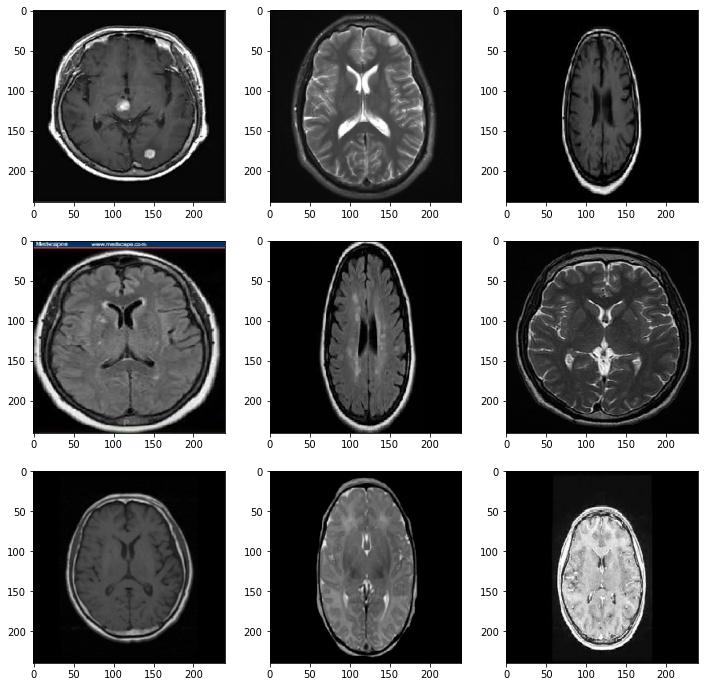

In [61]:
plot_state('no')

In [64]:
x_train.shape

(202, 240, 240, 3)

In [71]:


model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])



In [72]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

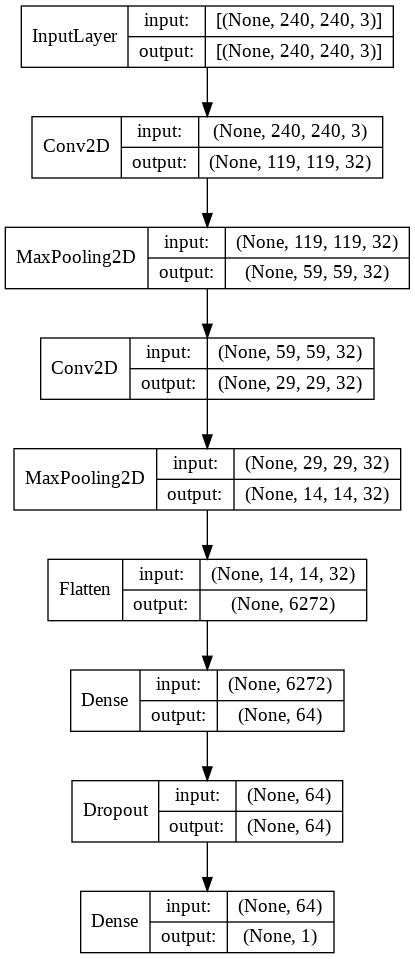

In [73]:
plot_model(model, show_shapes=True, show_layer_names=False)

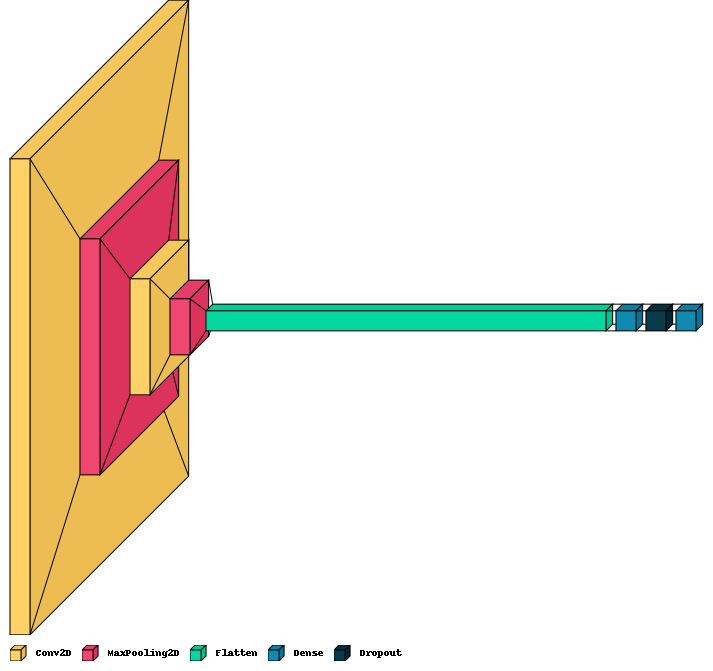

In [76]:
visualkeras.layered_view(model, legend=True)

In [82]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.294871794871795, 1: 0.8145161290322581}

In [83]:
history = model.fit(x_train,y_train,epochs = 100, class_weight=class_weights, validation_data=(x_test, y_test),verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 291ms/step - loss: 22.6075 - accuracy: 0.5099 - val_loss: 6.2729 - val_accuracy: 0.5882
Epoch 2/100
7/7 [==============================] - 1s 194ms/step - loss: 6.0469 - accuracy: 0.3861 - val_loss: 5.7146 - val_accuracy: 0.6078
Epoch 3/100
7/7 [==============================] - 2s 287ms/step - loss: 5.5383 - accuracy: 0.4950 - val_loss: 5.2933 - val_accuracy: 0.3922
Epoch 4/100
7/7 [==============================] - 1s 190ms/step - loss: 5.1775 - accuracy: 0.5644 - val_loss: 5.0218 - val_accuracy: 0.6078
Epoch 5/100
7/7 [==============================] - 1s 190ms/step - loss: 4.9639 - accuracy: 0.6139 - val_loss: 4.8731 - val_accuracy: 0.5686
Epoch 6/100
7/7 [==============================] - 1s 189ms/step - loss: 4.8109 - accuracy: 0.6040 - val_loss: 4.7155 - val_accuracy: 0.6078
Epoch 7/100
7/7 [==============================] - 1s 190ms/step - loss: 4.6683 - accuracy: 0.3663 - val_loss: 4.5948 - val_accuracy: 0.4314
Epoch 8/100


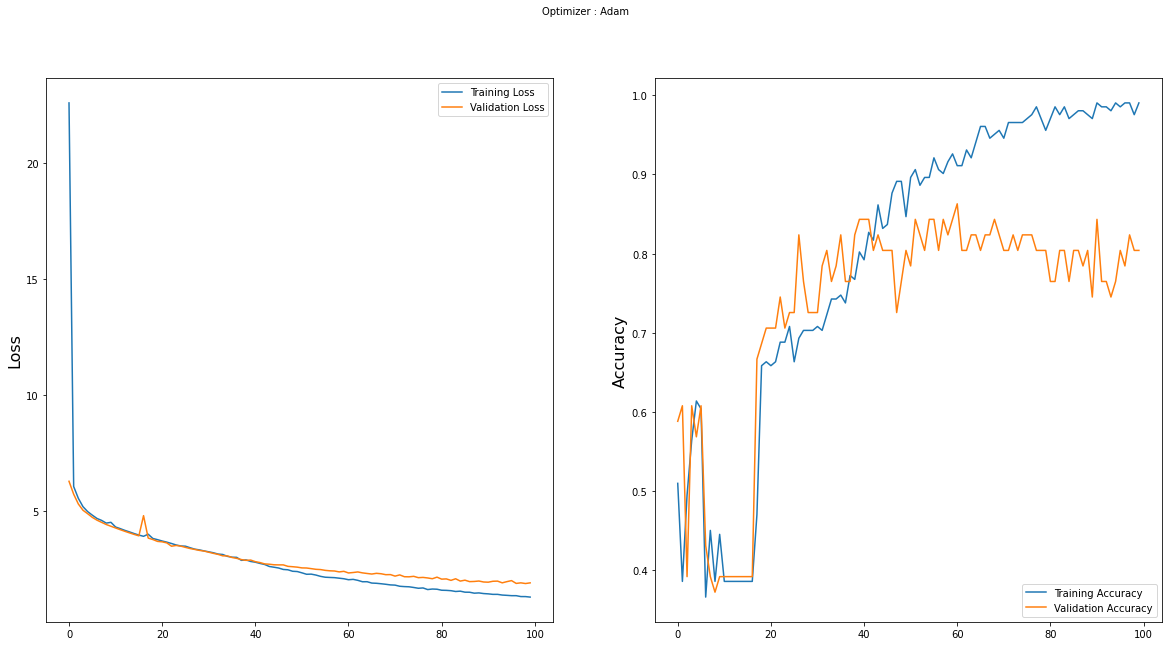

In [84]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()